In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import operator

from sklearn.metrics import r2_score, mean_squared_error, make_scorer

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import ElasticNetCV

# To install: conda install py-xgboost
import xgboost as xgb

# Adjust screen output size
#pd.util.terminal.get_terminal_size() # get current size
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)

### Dataset 3 with: original RGB data, dummy Google Places & Amenities Data

In [2]:
data = pd.read_csv('data_test3.csv', index_col=0)
# get train portion
train = data[data['dataset']=='train']
# drop id, dataset
train = train.drop(['id', 'dataset'], axis=1)
#train.isnull().sum() # None missing

In [3]:
# Split out predictors from target
y_data = train['log_price']
x_data = train.drop(['log_price'], axis=1)
# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.26, random_state=11)

##### Elastic Net

In [4]:
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)

elasticNet.fit(x_train, y_train)
y_test_elas = elasticNet.predict(x_test)

In [5]:
# What is r2 score?
r2_score(y_test, y_test_elas) 

0.64971321647301861

In [6]:
math.sqrt(mean_squared_error(y_test, y_test_elas))

0.42543927926433933

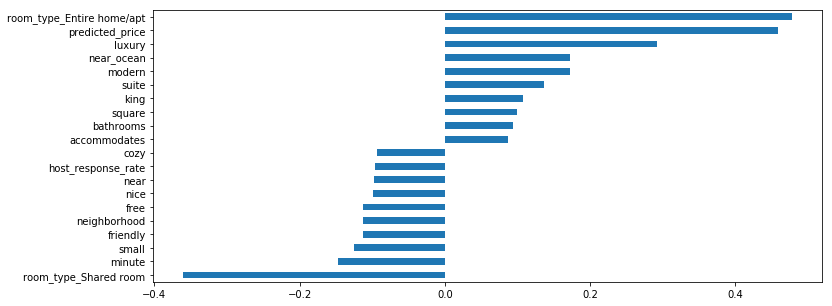

In [7]:
# What are the important coefficients?
plt.figure(figsize=(12,5))
coefs_elas = pd.Series(elasticNet.coef_, index=x_train.columns)
import_coefs_elas = pd.concat([coefs_elas.sort_values().head(10), coefs_elas.sort_values().tail(10)])
import_coefs_elas.plot(kind='barh')

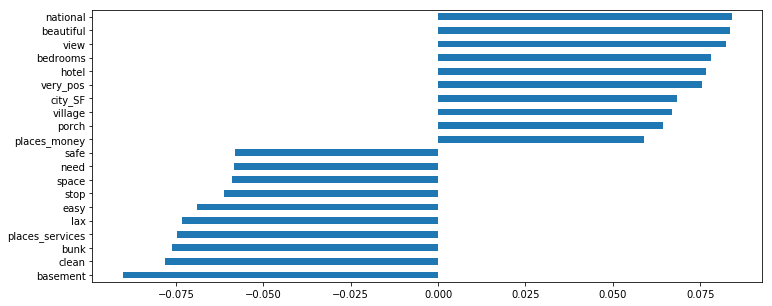

In [8]:
# What about the next 10 coefficients?
plt.figure(figsize=(12,5))
coefs_elas = pd.Series(elasticNet.coef_, index=x_train.columns)
import_coefs_elas = pd.concat([coefs_elas.sort_values()[10:20], coefs_elas.sort_values()[-20:-10]])
import_coefs_elas.plot(kind='barh')

In [9]:
# What were the dropped vars?
print("Elastic Net picked " + str(sum(coefs_elas != 0)) + " features and eliminated the other " +  \
      str(sum(coefs_elas == 0)) + " features")

Elastic Net picked 145 features and eliminated the other 171 features


In [10]:
# What were the features dropped
coefs_elas[coefs_elas==0]

walk                         -0.0
big                           0.0
many                         -0.0
entire                        0.0
couch                        -0.0
charming                      0.0
near_small_water             -0.0
famous                        0.0
relax                         0.0
busy                         -0.0
vintage                      -0.0
culture                       0.0
fresh                         0.0
sport                         0.0
music                        -0.0
smoke                        -0.0
traffic                      -0.0
pet                           0.0
queen                        -0.0
complimentary                 0.0
distance                      0.0
spacious                     -0.0
fully                        -0.0
pizza                        -0.0
love                         -0.0
everything                    0.0
light                        -0.0
table                        -0.0
air                          -0.0
short         

##### XGBoost Regressor

In [11]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

xgb_params = {
    'eta': 0.037,
    'max_depth': 10,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'base_score': np.mean(y_train),
    'silent': 0
}

model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=242)

In [12]:
print('RMSE:', mean_squared_error(model.predict(dtrain), y_train)**(1/2))

RMSE: 0.26085569915


In [13]:
importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)

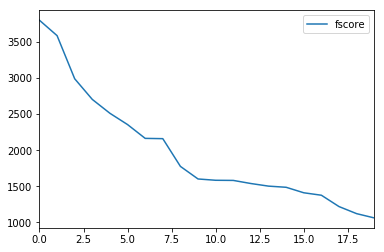

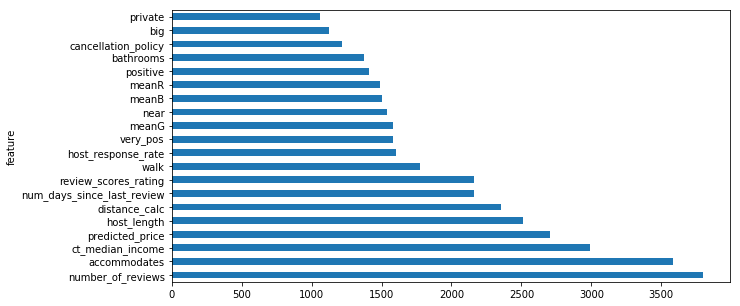

In [14]:
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
# plot top 100 features 
plt.figure()
df.head(20).plot()
df.head(20).plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))